<a href="https://colab.research.google.com/github/FedyaBadyilo/Skin-Cancer-Detection/blob/main/metadata_classification_lgbm_catboost_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install catboost; pip install optuna; pip install dask[dataframe]; pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 15.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, make_scorer, precision_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv as cb_cross_val, Pool
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler
import shap

import tqdm
import time

import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

# импорт данных

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISIC_hack/train_metadata_2')

In [5]:
num_cols = [
    'age_approx',                        # Приблизительный возраст пациента на момент снимка.
    'clin_size_long_diam_mm',            # Максимальный диаметр очага в миллиметрах.
    'tbp_lv_A',                          # A внутри очага.
    'tbp_lv_Aext',                       # A снаружи очага.
    'tbp_lv_B',                          # B внутри очага.
    'tbp_lv_Bext',                       # B снаружи очага.
    'tbp_lv_C',
    # Хрома внутри очага.
    'tbp_lv_Cext',                       # Хрома снаружи очага.
    'tbp_lv_H',                          # Оттенок внутри очага; рассчитывается как угол A* и B* в цветовом пространстве LAB*. Типичные значения варьируются от 25 (красный) до 75 (коричневый).
    'tbp_lv_Hext',                       # Оттенок снаружи очага.
    'tbp_lv_L',                          # L внутри очага.
    'tbp_lv_Lext',                       # L снаружи очага.
    'tbp_lv_areaMM2',                    # Площадь очага (мм²).
    'tbp_lv_area_perim_ratio',           # Неровность границы, соотношение между периметром и площадью очага. Круглые очаги будут иметь низкие значения; неравномерно сформированные очаги будут иметь более высокие значения. Значения варьируются от 0 до 10.
    'tbp_lv_color_std_mean',             # Неровность цвета, рассчитывается как дисперсия цветов в пределах границы очага.
    'tbp_lv_deltaA',                     # Средний контраст A (внутри и снаружи очага).
    'tbp_lv_deltaB',                     # Средний контраст B (внутри и снаружи очага).
    'tbp_lv_deltaL',                     # Средний контраст L (внутри и снаружи очага).
    'tbp_lv_deltaLB',                    # Контраст между очагом поражения и кожей, непосредственно окружающей его. Малоконтрастные очаги поражения, как правило, слабо заметны, например, веснушки; высококонтрастные очаги поражения, как правило, имеют более темный пигмент. Рассчитывается как среднее значение дельта-LB очага поражения относительно его непосредственного фона в цветовом пространстве LAB*. Типичные значения варьируются от 5,5 до 25.+
    'tbp_lv_deltaLBnorm',                # Контраст между очагом и его ближайшей окружающей кожей. Очаги с низким контрастом, как правило, слабо видны, например, веснушки; очаги с высоким контрастом, как правило, имеют более темный пигмент. Рассчитывается как среднее значение delta LB очага относительно его непосредственного фона в цветовом пространстве LAB*. Типичные значения варьируются от 5.5 до 25.
    'tbp_lv_eccentricity',               # Эксцентриситет.
    'tbp_lv_minorAxisMM',                # Минимальный диаметр очага (мм).
    'tbp_lv_nevi_confidence',            # Оценка уверенности в невусе (по шкале от 0 до 100) — это вероятность, оцененная классификатором на основе свёрточной нейронной сети, что очаг является невусом. Нейронная сеть была обучена на примерно 57,000 очагов, которые были классифицированы и помечены дерматологом.
    'tbp_lv_norm_border',                # Неровность границы (по шкале от 0 до 10); нормализованное среднее значение неровности границы и асимметрии.
    'tbp_lv_norm_color',                 # Вариация цвета (по шкале от 0 до 10); нормализованное среднее значение цветовой асимметрии и неровности цвета.
    'tbp_lv_perimeterMM',                # Периметр очага (мм).
    'tbp_lv_radial_color_std_max',       # Цветовая асимметрия, мера асимметрии пространственного распределения цвета внутри очага. Этот показатель рассчитывается на основе средней стандартной девиации в цветовом пространстве LAB* в пределах концентрических колец, исходящих из центра очага. Значения варьируются от 0 до 10.
    'tbp_lv_stdL',                       # Стандартное отклонение L внутри очага.
    'tbp_lv_stdLExt',                    # Стандартное отклонение L снаружи очага.
    'tbp_lv_symm_2axis',                 # Асимметрия границы; мера асимметрии контура очага относительно оси, перпендикулярной к наиболее симметричной оси очага. Очаги с двумя осями симметрии будут иметь низкие значения (более симметричные), в то время как очаги с одной или нулевой осями симметрии будут иметь более высокие значения (менее симметричные). Этот показатель рассчитывается путем сравнения противоположных половин контура очага при различных углах поворота. Угол, при котором половины наиболее похожи, определяет главную ось симметрии, а вторая ось симметрии перпендикулярна главной оси. Асимметрия границы измеряется как значение асимметрии относительно этой второй оси. Значения варьируются от 0 до 10.
    'tbp_lv_symm_2axis_angle',           # Угол асимметрии границы очага.
    'tbp_lv_x',                          # X-координата очага в 3D TBP.
    'tbp_lv_y',                          # Y-координата очага в 3D TBP.
    'tbp_lv_z',                          # Z-координата очага в 3D TBP.
]

cat_cols = ['sex', # пол
            'anatom_site_general', # анатомическое место очага
            'tbp_tile_type', # Режим освещения исходного изображения 3D TBP
            'tbp_lv_location', # Классификация анатомического расположения делит руки и ноги на верхнюю и нижнюю части туловища на три части
            'tbp_lv_location_simple', # Классификация анатомического расположения, простая
            'attribution' # атрибуция изображения, синоним источника изображения
]

feature_cols = num_cols + cat_cols

norm_cols = [col for col in df.columns if 'combined_with' in col]

new_num_cols = [
'lesion_size_ratio',# tbp_lv_minorAxisMM / clin_size_long_diam_mm
'lesion_shape_index', # tbp_lv_areaMM2/ tbp_lv_perimeterMM **2
'hue_contrast',# tbp_lv_H - tbp_lv_Hextabs
'luminance_contrast', # tbp_lv_L - tbp_lv_Lextabs
'lesion_color_difference', # tbp_lv_deltaA **2+ tbp_lv_deltaB **2 + tbp_lv_deltaL **2sqrt
'border_complexity',# tbp_lv_norm_border + tbp_lv_symm_2axis
'color_uniformity', # tbp_lv_color_std_mean / tbp_lv_radial_color_std_max
'position_distance_3d',# tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2sqrt
'perimeter_to_area_ratio', # tbp_lv_perimeterMM / tbp_lv_areaMM2
'area_to_perimeter_ratio', # tbp_lv_areaMM2/ tbp_lv_perimeterMM
'lesion_visibility_score', # tbp_lv_deltaLBnorm + tbp_lv_norm_color
'symmetry_border_consistency',# tbp_lv_symm_2axis* tbp_lv_norm_border
'consistency_symmetry_border',# tbp_lv_symm_2axis* tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)
'color_consistency',# tbp_lv_stdL / tbp_lv_Lext
'consistency_color',# tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
'size_age_interaction',# clin_size_long_diam_mm* age_approx
'hue_color_std_interaction',# tbp_lv_H * tbp_lv_color_std_mean
'lesion_severity_index', # tbp_lv_norm_border + tbp_lv_norm_color + tbp_lv_eccentricity / 3
'shape_complexity_index',# border_complexity+ lesion_shape_index
'color_contrast_index',# tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm
'log_lesion_area',# tbp_lv_areaMM2+ 1np.log
'normalized_lesion_size',# clin_size_long_diam_mm/ age_approx
'mean_hue_difference',# tbp_lv_H + tbp_lv_Hext/ 2
'std_dev_contrast', # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2 / 3np.sqrt
'color_shape_composite_index',# tbp_lv_color_std_mean + bp_lv_area_perim_ratio + tbp_lv_symm_2axis / 3
'lesion_orientation_3d', # tbp_lv_y , tbp_lv_xnp.arctan2
'overall_color_difference',# tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL / 3
'symmetry_perimeter_interaction',# tbp_lv_symm_2axis* tbp_lv_perimeterMM
'comprehensive_lesion_index', # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis / 4
'color_variance_ratio',# tbp_lv_color_std_mean / tbp_lv_stdLExt
'border_color_interaction',# tbp_lv_norm_border * tbp_lv_norm_color
'border_color_interaction_2',
'size_color_contrast_ratio',# clin_size_long_diam_mm/ tbp_lv_deltaLBnorm
'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence/ age_approx
'age_normalized_nevi_confidence_2',
'color_asymmetry_index', # tbp_lv_symm_2axis* tbp_lv_radial_color_std_max
'volume_approximation_3d', # tbp_lv_areaMM2 * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
'color_range', # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
'shape_color_consistency', # tbp_lv_eccentricity * tbp_lv_color_std_mean
'border_length_ratio',# tbp_lv_perimeterMM / pi * sqrt(tbp_lv_areaMM2 / pi)
'age_size_symmetry_index', # age_approx * clin_size_long_diam_mm * tbp_lv_symm_2axis
'index_age_size_symmetry', # age_approx * tbp_lv_areaMM2 * tbp_lv_symm_2axis
'isic_count'
]

sampling_ratio = 0.5
seed = 42

In [6]:
class_weights = dict(zip([0, 1], compute_class_weight(class_weight="balanced", classes=np.unique(df['target']), y=df['target'])))
positive_class_weight = class_weights[1]/class_weights[0]
print(class_weights)
print(positive_class_weight)

{0: 0.5004904334283418, 1: 510.25318066157763}
1019.5063613231554


In [7]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])

    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return partial_auc

def custom_predict(estimator, X):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_pred = np.array([1.0 - x for x in y_hat])
    return v_pred

In [8]:
X = df[feature_cols + new_num_cols]
y = df['target']
groups = df['patient_id']
cv = StratifiedGroupKFold(10, shuffle=True)

# optuna hypo tuning

найдем лучшие гиперпараметры для бустингов

In [ ]:
gpu = False

In [ ]:
def cb_objective(trial):
    params = {
        'loss_function':     'Logloss',
        'iterations':        trial.suggest_int('iterations', 100, 300),
        'verbose':           False,
        'random_state':      seed,
        'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 2, 8),
        'l2_leaf_reg':       trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 5, 100),
        'scale_pos_weight':  trial.suggest_float('scale_pos_weight', 1.0, 50.0),
        # 'auto_class_weights': 'Balanced',
        'cat_features': cat_cols,
    }

    if gpu:
      params['task_type'] = 'GPU'
      params['colsample_bylevel'] = None

    estimator = Pipeline([
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1345)),
    ('classifier', CatBoostClassifier(**params))
])


    val_score = cross_val_score(
        estimator=estimator,
        X=X, y=y,
        cv=cv,
        groups=groups,
        scoring=custom_metric,
    )

    return np.mean(val_score)

In [ ]:
def xgb_objective(trial):
    params = {
        'objective':          'binary:logistic',
        'n_estimators':       trial.suggest_int('iterations', 100, 300),
        'tree_method':        'hist',
        'random_state':       seed,
        'learning_rate':      trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':          trial.suggest_int('max_depth', 2, 8),
        'lambda':             trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha':              trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample':          trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree':   trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode':   trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'scale_pos_weight':   trial.suggest_float('scale_pos_weight', 1.0, 50.0),
    }

    if gpu:
      params['device'] = 'cuda'

    estimator = Pipeline([
        ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1345)),
        ('classifier', XGBClassifier(**params)),
    ])

    val_score = cross_val_score(
        estimator=estimator,
        X=X, y=y,
        cv=cv,
        groups=groups,
        scoring=custom_metric,
    )

    return np.mean(val_score)

In [ ]:
def lgb_objective(trial):
    params = {
        'objective':         'binary',
        'verbosity':         -1,
        'n_iter': trial.suggest_int('iterations', 100, 300),
        'boosting_type':  'gbdt',
        'lambda_l1':         trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
        'lambda_l2':         trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 2, 8),
        'num_leaves':        trial.suggest_int('num_leaves', 16, 256),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode':  trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'bagging_fraction':  trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq':      trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 5, 100),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 1.0, 50.0),
        # 'is_unbalance': True,
    }

    # if gpu:
    #   params['device'] = 'gpu'

    estimator = Pipeline([
        ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1345)),
        ('classifier', LGBMClassifier(**params)),
    ])


    val_score = cross_val_score(
        estimator=estimator,
        X=X, y=y,
        cv=cv,
        groups=groups,
        scoring=custom_metric,
    )

    return np.mean(val_score)

In [ ]:
DO_TUNING = False

if DO_TUNING:
    start_time = time.time()
    study_cb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
    study_cb.optimize(cb_objective, n_trials=100, )
    end_time = time.time()
    elapsed_time_cb = end_time - start_time
    print(f"CatBoost tuning took {elapsed_time_cb:.2f} seconds.")

    start_time = time.time()
    study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
    study_lgb.optimize(lgb_objective, n_trials=100)
    end_time = time.time()
    elapsed_time_lgb = end_time - start_time
    print(f"LightGBM tuning took {elapsed_time_lgb:.2f} seconds.")

    start_time = time.time()
    study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
    study_xgb.optimize(xgb_objective, n_trials=100)
    end_time = time.time()
    elapsed_time_xgb = end_time - start_time
    print(f"XGBoost tuning took {elapsed_time_xgb:.2f} seconds.")

    print("Best LGBM trial:", study_lgb.best_trial, 'Best LGBM params', study_lgb.best_params)
    print("Best CatBoost trial:", study_cb.best_trial, "Best CatBoost params:", study_cb.best_params)
    print("Best XGBoost trial:", study_xgb.best_trial, "Best XGBoost params:", study_xgb.best_params)

In [ ]:
# catboost 'loss_function': 'Logloss', 'verbose': False, 'random_state': seed,

In [ ]:
# xgboost 'objective': 'binary:logistic','tree_method': 'hist','random_state': seed,

In [ ]:
# lgbm 'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt',

In [11]:
lgbm_best_params = {'iterations': 289, 'lambda_l1': 0.012983426942270367, 'lambda_l2': 0.1504652880960131, 'learning_rate': 0.042137817058755175, 'max_depth': 7, 'num_leaves': 183, 'colsample_bytree': 0.8380766811272908, 'colsample_bynode': 0.7375180588509996, 'bagging_fraction': 0.8145095404002428, 'bagging_freq': 1, 'min_data_in_leaf': 62, 'scale_pos_weight': 20.420204451700446, 'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt',}

In [12]:
xgb_best_params = {'iterations': 263, 'learning_rate': 0.03781802457077402, 'max_depth': 5, 'lambda': 0.049467102864737406, 'alpha': 0.4671866310443796, 'subsample': 0.8298001879700736, 'colsample_bytree': 0.7971142179795397, 'colsample_bynode': 0.7308414548523382, 'scale_pos_weight': 9.14514917702281,  'objective': 'binary:logistic','tree_method': 'hist','random_state': seed,}

In [13]:
cb_best_params = {'iterations': 292, 'learning_rate': 0.04850803566428528, 'max_depth': 7, 'l2_leaf_reg': 2.9954542772552255, 'colsample_bylevel': 0.46502886942279864, 'min_data_in_leaf': 9, 'scale_pos_weight': 3.2397593624833263, 'loss_function': 'Logloss', 'verbose': False, 'random_state': seed,}

# features selection and interpretation

проанализируем важность признаков и их интепретируемость, а также отберем признаки для бустингов с помощью shap_values и взглянем, какие из них являются наиболее значимыми для модели

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

In [ ]:
for model, params in ((CatBoostClassifier, cb_best_params), (LGBMClassifier, lgbm_best_params), (XGBClassifier, xgb_best_params)):
  pipe = Pipeline([
      ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1345)),
      ('classifier', model(**params))
  ])

  val_score = cross_validate(
    estimator=pipe,
    X=X, y=y,
    cv=cv,
    groups=groups,
    scoring={'recall': make_scorer(recall_score), 'custom_metric': custom_metric, 'precision': make_scorer(precision_score)},
    n_jobs=-1
  )

  print(f'recall: {np.mean(val_score["test_recall"])} precision: {np.mean(val_score["test_precision"])} custom_metric: {np.mean(val_score["test_custom_metric"])}')

recall: 0.8492988948230407 precision: 0.00873560125253104 custom_metric: 0.15737024667903504
recall: 0.9422692580358086 precision: 0.0032972152911143124 custom_metric: 0.15226056655057302
recall: 0.905249659597381 precision: 0.0054518307729925315 custom_metric: 0.1567525143340128


видно, что кастомная метрика позволяет получить так же и высокий recall при очень низкой метрике precision. на самом деле, все обусловлено тем, что в случае с определением злокачественных поражений модели лучше перестраховаться и ложно определить доброкачественное поражение к злокачественным (False Positive), чем не определить по-настощему злокачественную опухоль (True Positive). таким образом, шанс пропустить злокачественную опухоль минимален

In [ ]:
cat_model = Pipeline([
      ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1345)),
      ('classifier', CatBoostClassifier(**cb_best_params))
  ])
cat_model.fit(X_train, y_train)

xgb_model = Pipeline([
      ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1345)),
      ('classifier', XGBClassifier(**xgb_best_params))
  ])
xgb_model.fit(X_train, y_train)

lgbm_model = Pipeline([
      ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1345)),
      ('classifier', LGBMClassifier(**lgbm_best_params))
  ])
lgbm_model.fit(X_train, y_train);

In [ ]:
def show_feature_importance(model, X, show=True):
   explainer = shap.Explainer(model)
   shap_values = explainer(X)
   if show:
     shap.summary_plot(shap_values, X)

   return np.abs(shap_values.values).mean(axis=0)


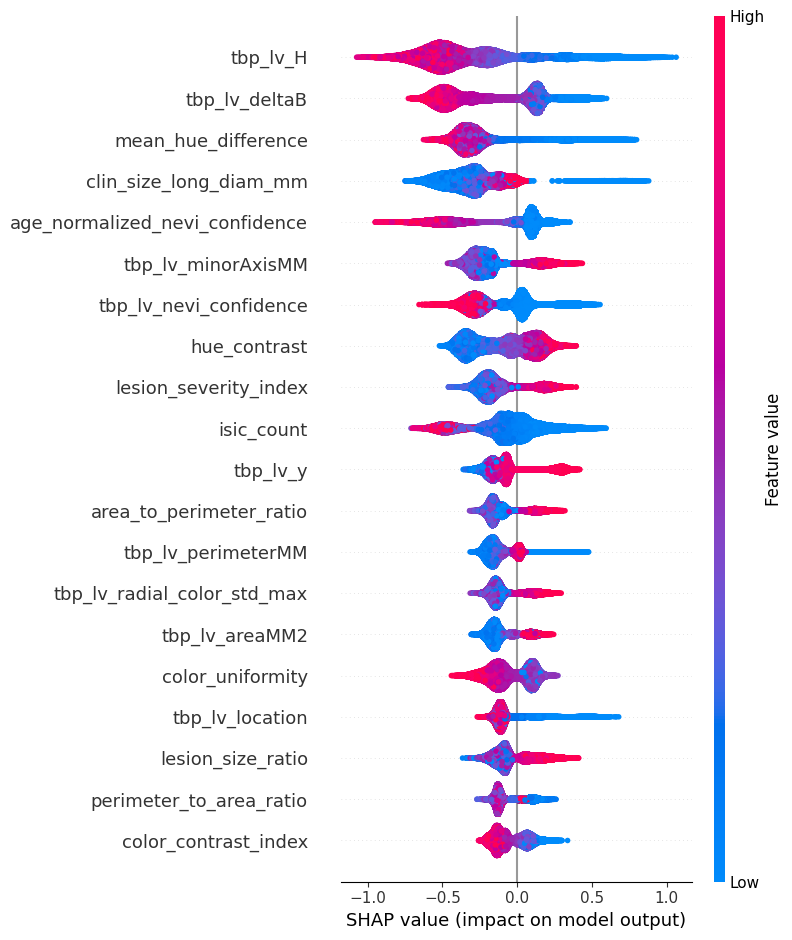

In [ ]:
shap_values_cat = show_feature_importance(cat_model[-1], X_test)

из данного графика видно, что наибольший вклад в решение модели вносят признаки `tbp_lv_H`, `tbp_lv_deltaB`, `mean_hue_difference`. причем становится ясно, что чем меньше значение `tbp_lv_H` (оттенок внутри очага), тем вероятнее данная облась является злокачественной. другими словами, чем краснее очаг, тем хуже поражение.

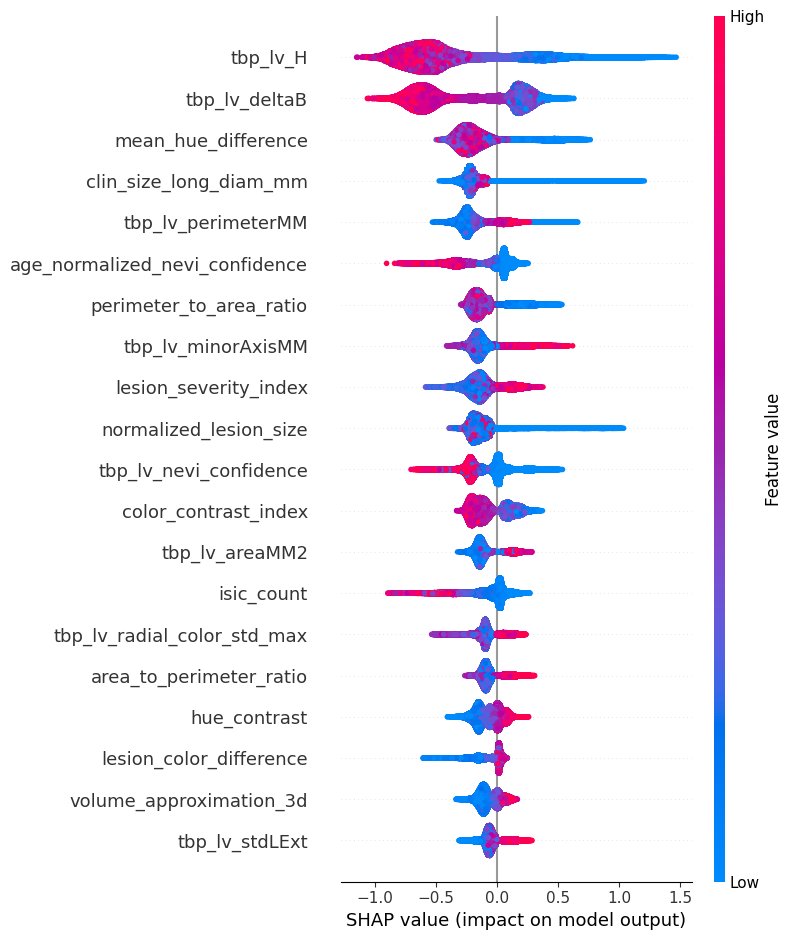

In [ ]:
shap_values_xgb = show_feature_importance(xgb_model[-1], X_test)

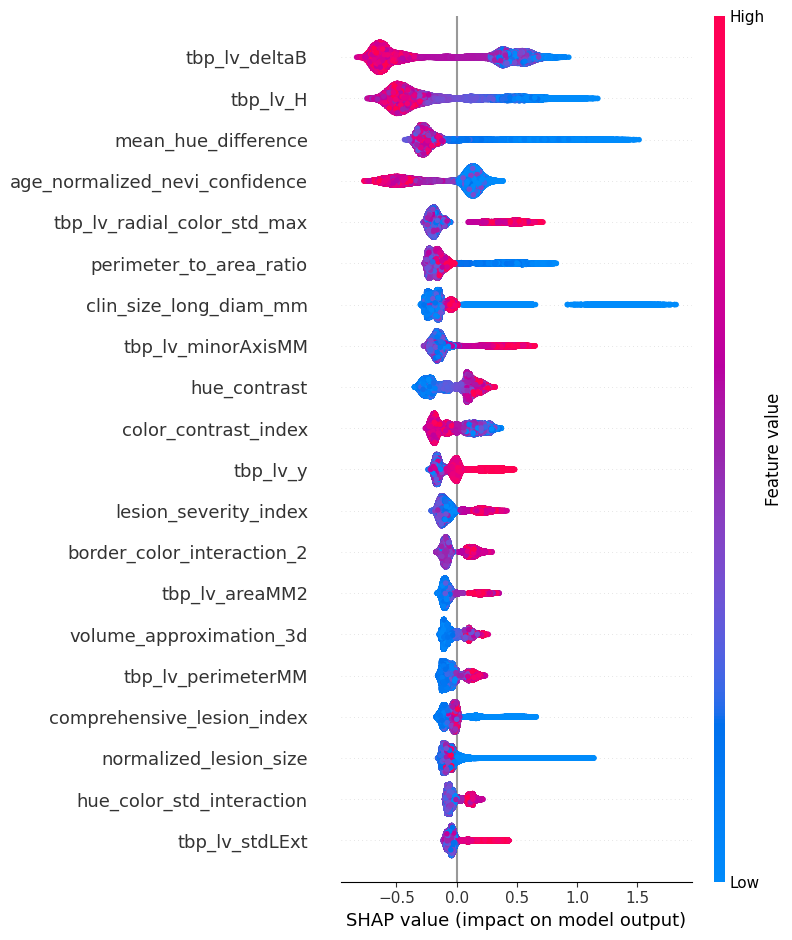

In [ ]:
shap_values_lgbm = show_feature_importance(lgbm_model[-1], X_test)

для двух других моделей важность признаков примерно такая же.

посмотрим, как будут меняться показатели метрик при использовании только самых важных признаков

In [ ]:
treashold = 0.0

for model, params in ((CatBoostClassifier, cb_best_params),
  (XGBClassifier, xgb_best_params),
  (LGBMClassifier, lgbm_best_params)):

  pipe_1 = Pipeline([
      ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1345)),
      ('classifier', model(**params))
  ])
  cross_val_1 = cross_validate(
    estimator=pipe_1,
    X=X, y=y,
    cv=cv,
    groups=groups,
    scoring={'custom_metric': custom_metric, 'recall': make_scorer(recall_score), 'precision': make_scorer(precision_score)},
    n_jobs=-1
  )


  metrics_1 = {}
  print('BEFORE')
  for metric in cross_val_1:
    if 'test' in metric:
      metrics_1[metric] = np.mean(cross_val_1[metric])
      print(f'{metric}: {metrics_1[metric]}')

  pipe_1.fit(X_train, y_train)
  f_imp = show_feature_importance(pipe_1[-1], X_test, show=False)
  imp_cols = np.array(tuple(zip(X.columns, f_imp)))[f_imp > treashold][:, 0]

  pipe_2 = Pipeline([
      ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=1345)),
      ('classifier', model(**params))
  ])
  cross_val_2 = cross_validate(
    estimator=pipe_1,
    X=X[imp_cols], y=y,
    cv=cv,
    groups=groups,
    scoring={'custom_metric': custom_metric, 'recall': make_scorer(recall_score), 'precision': make_scorer(precision_score)},
    n_jobs=-1
  )

  metrics_2 = {}
  print('AFTER')
  for metric in cross_val_2:
    if 'test' in metric:
      metrics_2[metric] = np.mean(cross_val_2[metric])
      print(f'{metric}: {metrics_2[metric]}')
  if metrics_2['test_custom_metric'] > metrics_1['test_custom_metric']:
    print(f'new important features: {imp_cols}')

BEFORE
test_custom_metric: 0.15904105758984488
test_recall: 0.847260160233378
test_precision: 0.008635505474912469
AFTER
test_custom_metric: 0.15789961092694446
test_recall: 0.8497663007391862
test_precision: 0.008802293450456784
BEFORE
test_custom_metric: 0.15722873418361577
test_recall: 0.90409872059794
test_precision: 0.005300974498958268
AFTER
test_custom_metric: 0.15510746650528884
test_recall: 0.8976902924797662
test_precision: 0.00547878941801101
BEFORE
test_custom_metric: 0.15557457625675358
test_recall: 0.9402524880961785
test_precision: 0.0032275948499977435
AFTER
test_custom_metric: 0.15204233899140313
test_recall: 0.9405524227234754
test_precision: 0.00330438263870038


таким образом, ни у одного бустинга не выросла кастомная метрика при отборе параметров

# voting classifier

In [20]:
cat_model = Pipeline([
      ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
      ('classifier', CatBoostClassifier(**cb_best_params))
  ])

xgb_model = Pipeline([
      ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
      ('classifier', XGBClassifier(**xgb_best_params))
  ])

lgbm_model = Pipeline([
      ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
      ('classifier', LGBMClassifier(**lgbm_best_params))
  ])

In [21]:
estimator = VotingClassifier([
    ('lgbm', lgbm_model), ('cb', cat_model), ('xgb', xgb_model),
], voting='soft')

In [22]:
val_score_final = cross_validate(
    estimator=estimator,
    X=X, y=y,
    cv=cv,
    groups=groups,
    scoring={'custom_metric': custom_metric, 'recall': make_scorer(recall_score), 'precision': make_scorer(precision_score)},
)

In [23]:
for metric in val_score_final:
  if 'test' in metric:
    print(f'{metric}: {np.mean(val_score_final[metric])}')

test_custom_metric: 0.16253466147413248
test_recall: 0.4234127015856874
test_precision: 0.07920153341516001


при использовании voting classifier кастомная метрика дала небольшой рост